# Multilayer Perceptron
*Deep feedforward networks*, also often called feedforward neural networks, or *multilayer perceptrons (MLPs)*, are the quintessential deep learning models. The goal of a feedforward network is to approximate some function $f^*$.
For example, for a classifier, $y = f^∗(x)$ maps an input $x$ to a category $y$. Like logistic regression, a feedforward network also defines a mapping $y =f(x;\theta)$ and learns the value of the parameters $\theta$ that result in the best function approximation. The difference is that logistic regression simply uses a linear predictor, while the models chosen by MLPs are non-linear and more complicated than that. 

For *feedforward networks*, information flows through the function in one direction: data is binded and evaluated from $x$, through the intermediate computations used to define $f$, and finally to the output $y$. The function has a structure like a *network*, or chain. For example, a model with depth $k$ is represented by functions $f^{(1)}, f^{(2)}, \cdots, f^{(k)}$ to form $f(x) = f^{(k)}(\cdots (f^{(2)}(f^{(1)}(x))))$. Each function $f^{(i)}(\cdot)$ is a layer of the network. 


## Data handling
We use the same data as we used in logistic regression: [Santander Customer Satisfaction](http://www.kaggle.com/c/santander-customer-satisfaction). We download the data, convert it to NDArray and prepare for the object of Data Iter by calling the mxnet.io.NDArrayIter function. 

In [1]:
import mxnet as mx
import os
import urllib
def getData(fname):
    data=[]
    label=[]
    firstline=True
    for line in file(fname):
        if (firstline):
            firstline=False
            continue
        tks = line.strip().split(',')
        data.append([float(i) for i in tks[1:-2]]) # omit the first column of user ID.
        label.append(int(tks[-1]))
    return mx.nd.array(data),mx.nd.array(label)
if not os.path.exists('train.csv'):
    urllib.urlretrieve('https://www.kaggle.com/c/santander-customer-satisfaction/download/train.csv.zip', 'train.csv')
if not os.path.exists('test.csv'):
    urllib.urlretrieve('https://www.kaggle.com/c/santander-customer-satisfaction/download/test.csv.zip', 'test.csv')
X_train,y_train=getData('train.csv')


Usually it's not very trustworthy to evaluate the performance on the training set, since a sophisticated model could easily overfit on the training data. Instead, we split the data into two parts, one for training, and the other one for validation. 

In [2]:
n=int(X_train.shape[0])
n_val=int(n/10)
X_val=X_train[:n_val]
y_val=y_train[:n_val]
X_train=X_train[n_val:]
y_train=y_train[n_val:]
print X_train.shape
batch_size = 100
train_iter=mx.io.NDArrayIter(X_train,y_train, batch_size, shuffle=True)
val_iter=mx.io.NDArrayIter(X_val,y_val,batch_size)

(68418L, 368L)


After preparing for the data, we discuss what exactly is the model for Multilayer Perceptrons and show how to easily train the model on the training data by MXNet.

## Model specification
A multilayer perceptron contains several fully-connected layers. A fully-connected layer, with an $n \times m$ input matrix $X$ outputs a matrix $Y$ with size $n \times k$, where $k$ is often called as the hidden size. This layer has two parameters, the $m \times k$ weight matrix $W$ and the $m \times 1$ bias vector $b$. It computes the outputs with
$Y=WX+b.$

The output of a fully-connected layer is often fed into an activation layer, which performs element-wise operations. Two common options are the sigmoid function, or the rectifier (or “relu”) function, which outputs the max of 0 and the input. The activation step makes the function of each layer non-linear, and potentially is able to represent more .

The last fully-connected layer often has the hidden size equals to the number of classes in the dataset. Then we stack a softmax layer, which map the input into a probability score. Again assume the input $X$ has size $n \times m$:

$$\left[\frac{\exp(x_{i1})}{\sum_{j=1}^m\exp(x_{ij})},\cdots, \frac{\exp(x_{im})}{\sum^m_{j=1}\exp(x_{ij})}\right]$$

Defining the multilayer perceptron in MXNet is straightforward, which has shown as following.

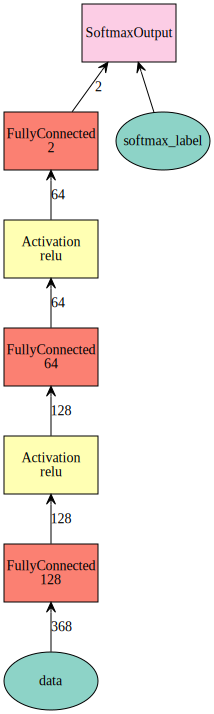

In [3]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 2, which is the number of classes
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=2)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 368)}
mx.viz.plot_network(symbol=mlp, shape=shape)

Hereby we define the two layered network with ReLu activation function, and softmax output. Now the parameters to define each layer are unknown, and should be trained by fitting in the input data and use some proper optimization algorithms stated as follows:

## Back-propagation and training process
For a feedforward neural network, it inputs some data $x$ and produces an output $\hat{y}$, where information flows forward through the network. The inputs $x$ provide the initial information that then propagates up to the hidden units at each layer and finally produces $\hat{y}$. This is called forward propagation. During training, forward propagation can continue onward until it produces a scalar cost related to parameters $\theta$ associated with each layer. The *back-propagation algorithm*, often simply called *backprop*, allows the information from the cost to then flow backwards through the network, in order to compute the gradient. In a nutshell, back-propagation uses chain rule to numerically compute the gradient with respect to each batch of data and update accordingly to optimize distance between output $\hat{y}$ and the true labels. 

The mxnet model wraps up the back-propagation algorithm inside and simplifies the whole training process in just several lines of code:

In [4]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 3,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 1000 data batches
)

INFO:root:Start training with [cpu(0)]


[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


INFO:root:Epoch[0] Batch [200]	Speed: 84701.93 samples/sec	Train-accuracy=0.944450
INFO:root:Epoch[0] Batch [400]	Speed: 88498.35 samples/sec	Train-accuracy=0.960300
INFO:root:Epoch[0] Batch [600]	Speed: 114851.55 samples/sec	Train-accuracy=0.960350
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.724
INFO:root:Epoch[0] Validation-accuracy=0.959740
INFO:root:Epoch[1] Batch [200]	Speed: 113232.41 samples/sec	Train-accuracy=0.961700
INFO:root:Epoch[1] Batch [400]	Speed: 96695.53 samples/sec	Train-accuracy=0.960300
INFO:root:Epoch[1] Batch [600]	Speed: 96386.10 samples/sec	Train-accuracy=0.960350
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.716
INFO:root:Epoch[1] Validation-accuracy=0.959740
INFO:root:Epoch[2] Batch [200]	Speed: 98423.30 samples/sec	Train-accuracy=0.961700
INFO:root:Epoch[2] Batch [400]	Speed: 119571.30 samples/sec	Train-accuracy=0.960300
INFO:root:Epoch[2] Batch [600]	Speed: 103394.44 samples/sec	Train-accuracy=0.9603

We can easily evaluate the performance by validation accuracy:

In [7]:
valid_acc = model.score(val_iter)
print 'Validation accuracy: %f%%' % (valid_acc *100,)
assert valid_acc > 0.95, "Low validation accuracy."

Validation accuracy: 95.974026%
